In [1]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag
from numpy import linalg as LA


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
xinj_to_Einj = 4.698e-4/2. #Einj = 4.698e-4/2 xinj
mass_to_Einj = 1./2.
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass,  ' +r'$m_\mathrm{X}\quad[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_Zeta_e = 'Ionization History, '+r'$\zeta(z) = \Delta X_\mathrm{e}/X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"

label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_Gamma_stim = r"$\Gamma_X^\mathrm{stim}/\Gamma_X=[1+2n_\mathrm{Pl}(x_\mathrm{inj})]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'

label_log10Tau_x = "Lifetime,  "+r'$\mathrm{log}_{10}(\tau_X/\,1\mathrm{s})$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'
label_log10injection_energy = "Injection Energy, "+ r'$\mathrm{log}_{10}(E_{\mathrm{inj,0}}/\,1\mathrm{eV})$'
label_log10mdm = 'Particle Mass, ' +r'$\mathrm{log}_{10}(m_\mathrm{X}/\,1\mathrm{eV})$'
sd = pi


find_nearests = sd.find_nearests
#from scipy.interpolate import interp1d

def get_fdm_constraints_at_Gamma_and_xinj(gamma_p,xinj_p,*args,**kwargs):
    a_lib = kwargs['sd_lib']
    f_dm_fisher = sd.pi_run_fisher_constraints([gamma_p],[xinj_p],**kwargs)
    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
    #fdm_value = GetSpectra(gamma_p,xinj_p,x_asked,a_lib,get_fisher_fdm='yes',use_edges='yes')["fisher_fdm"]
    fdm_pca_value_ct = np.nan
    fdm_pca_value_rf = np.nan
    if gamma_p < 1e-12:
        # using recfast:
        #f_dm_pca = pi_run_pca_constraints_with_recfast([xinj_p],[gamma_p],fdm_value,**kwargs)
        #fdm_pca_value_rf = f_dm_pca['curves'][0]['fdm'][0]
        
        # using CT:
        z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
        S_xe_history = sd.GetXeHistory(gamma_p,xinj_p,z_asked,a_lib)
        fdm_pca_value_ct = S_xe_history['fdm_pca_lim']
    r_dict = {}
    r_dict['fdm_fisher'] = fdm_value
    r_dict['fdm_Xe_pca_rf'] = fdm_pca_value_rf
    r_dict['fdm_Xe_pca_ct'] = fdm_pca_value_ct
    return r_dict

def pi_run_pca_constraints_with_recfast(xinj_values,gammai_array,fdm,*args,**kwargs):
    PCA_eigen_modes = kwargs['PCA_modes']
    recfast = kwargs['recfast']
    f_dm_pca = {}
    f_dm_pca['curves'] = []
    f_dm_pca['xinj'] = []
    
    store_DXe_Xe = kwargs.get('store_DXe_Xe', 'no')
    
    
    z1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['z']
    E1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['values']
    z2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['z']
    E2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['values']
    z3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['z']
    E3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['values']
    
    f_E1 = interp1d(z1, E1)
    f_E2 = interp1d(z2, E2)
    f_E3 = interp1d(z3, E3)

    
    for xinj_asked in xinj_values:
        xdec = xinj_asked
        curves = {}
        curves['Gamma_inj'] = gammai_array
        if store_DXe_Xe == 'yes':
            curves['DXe_Xe'] = []

        #str_dir = str("%.3e"%xdec)

        recfast.rf_xinj0 = xdec
        recfast.rf_f_dec = fdm

        args = {}

        p_name = 'Gamma_dec'
        p_array = gammai_array

        args['param_values_array'] = p_array
        args['param_name'] = p_name
        args['save_recfast_results'] = 'no'
        #rf.save_dir_name = 'case_' + '_xdec_' + str_dir
        R = recfast.run_recfast_parallel(**args)


        recfast.rf_f_dec = 1.e-300
        #recfast.save_dir_name = 'case_no_inj' + '_xdec_' + str_dir
        R_no_inj = recfast.run_recfast_parallel(**args) 
        
        
        
        fdm_pca_array = []
        for k in range(len(R)):
            DXe_Xe = (R[k]['Xe']-R_no_inj[k]['Xe'])/R_no_inj[k]['Xe']
            z_Xe = R[k]['z']
            f_DXe_Xe = interp1d(z_Xe,DXe_Xe)
            
            min_z1 = max(np.min(z1),np.min(z_Xe))
            max_z1 = min(np.max(z1),np.max(z_Xe))

            min_z2 = max(np.min(z2),np.min(z_Xe))
            max_z2 = min(np.max(z2),np.max(z_Xe))

            min_z3 = max(np.min(z3),np.min(z_Xe))
            max_z3 = min(np.max(z3),np.max(z_Xe))
            
            new_z_min = max(min_z1,min_z2,min_z3)
            new_z_max = min(max_z1,max_z2,max_z3)
            
            new_z_min = 1e-5
            new_z_max = 4e3
            new_z = np.linspace(new_z_min,new_z_max,500)

            
            new_z1 = new_z#np.linspace(min_z1,max_z1,5000)
            new_z2 = new_z#np.linspace(min_z2,max_z2,5000)
            new_z3 = new_z#np.linspace(min_z3,max_z3,5000)
            
            zeta1 = f_DXe_Xe(new_z1)
            zeta2 = f_DXe_Xe(new_z2)
            zeta3 = f_DXe_Xe(new_z3)

            integrand_rho1 = zeta1*f_E1(new_z1)
            integrand_rho2 = zeta2*f_E2(new_z2)
            integrand_rho3 = zeta3*f_E3(new_z3)
            
            

            rho1 = np.trapz(integrand_rho1, x=new_z1)/fdm
            rho2 = np.trapz(integrand_rho2, x=new_z2)/fdm
            rho3 = np.trapz(integrand_rho3, x=new_z3)/fdm
            #print(rho1,rho2,rho3)

            sigma1 = 0.12
            sigma2 = 0.19
            sigma3 = 0.35

            fdm_pca_lim = 2.*1./np.sqrt(rho1**2/sigma1**2+rho2**2/sigma2**2+rho3**2/sigma3**2)
            fdm_pca_array.append(fdm_pca_lim)
            if store_DXe_Xe == 'yes':
                curves['DXe_Xe'].append([new_z,f_DXe_Xe(new_z)])
                
            
        fdm_pca_array = np.asarray(fdm_pca_array)
        curves['fdm'] = fdm_pca_array
        
        
        
        
        
        f_dm_pca['xinj'].append(xdec)
        f_dm_pca['curves'].append(curves)
    return f_dm_pca


import matplotlib.animation as animation

In [228]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = np.logspace(-8,8,100)
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 0
ct.ct_zlate = 1e3
ct.ct_pi_energy_norm = 2
ct.ct_Drho_rho_dec = 3e-5
ct.ct_lyc = 1
ct.ct_evolve_Xe = 1
ct.ct_include_collisions = 0

ct.ct_Gamma_dec = 1e-6
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

#ct.ct_Drho_rho_dec = 3e-100
#R_test_no_inj = ct.run_cosmotherm_parallel(**args)
#i=0

In [230]:
R[1]

{'photon injection x_dec': 1.4508287784959402e-08,
 'z': array([4.95000000e+06, 4.90050000e+06, 4.85149500e+06, ...,
        2.02045515e-02, 2.00025060e-02, 1.00000000e-02]),
 '(NX/Nxini)': array([0.98053239, 0.96125035, 0.94202894, ..., 0.        , 0.        ,
        0.        ]),
 '(NX/Nxini)_stim': array([0., 0., 0., ..., 0., 0., 0.]),
 't_cosmic': array([9.73261730e+05, 9.93020582e+05, 1.01318055e+06, ...,
        4.26230886e+17, 4.26320514e+17, 4.30790901e+17]),
 't_stim': array([1.32832289e+21, 1.34173796e+21, 1.35528848e+21, ...,
        1.99685590e+26, 1.99698193e+26, 2.00323683e+26]),
 '[(dlnRho/dln1pz)/(dRho/Rho)_inj]': array([0.00141807, 0.00183086, 0.00234868, ..., 0.        , 0.        ,
        0.        ]),
 'finj': 402197660590.7544}

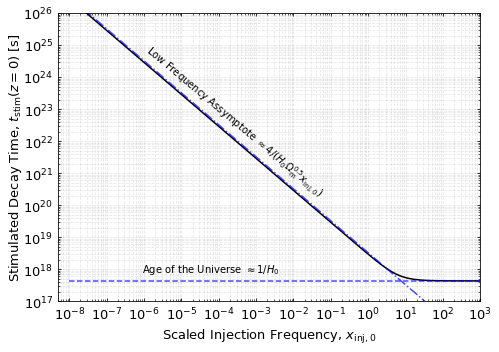

In [278]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


ax.set_xscale('log')
ax.set_yscale('log')

# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)


ax.set_ylabel(r'Stimulated Decay Time, $t_\mathrm{stim}(z=0)\,\,[\mathrm{s}]$',size=title_size)
ax.set_xlabel(label_injection_frequency,size=title_size)
ax.yaxis.set_label_coords(-.08,0.5)

#for label in ax.yaxis.get_ticklabels()[::2]:
#    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


array_x0 =[]
array_t_stim_today = []
array_t_today = []

for i in range(len(R)):
    xinj0 = R[i]['photon injection x_dec']
    t_stim_today = R[i]['t_stim'][-1]
    t_today = R[i]['t_cosmic'][-1]
    array_x0.append(xinj0 )
    array_t_stim_today.append(t_stim_today)
    array_t_today.append(t_today)
array_x0 = np.asarray(array_x0)
array_t_stim_today = np.asarray(array_t_stim_today)

ax.plot(array_x0,array_t_stim_today,c='k')

ax.plot(array_x0,array_t_today,ls='--',c='b',alpha=0.7)

#array_x0 = np.logspace(-8,8,100)

#z = 0.
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=0$',ls='-',c='k')
#z = 1e2
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{2}$',ls='--',c='k')
#z = 1e4
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{4}$',ls='-.',c='k')
#z = 1e6
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{6}$',ls=':',c='k')

cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

ax.plot(array_x0,4./array_x0/cosmo.H0()/np.sqrt(cosmo.Omega_m()),ls='-.',c='b',alpha=0.7)
#ax.plot(array_x0,1/cosmo.H0()*array_x0/array_x0)


ax.text(0.2,0.1,r'Age of the Universe $\approx 1/H_0$',transform = ax.transAxes,fontsize= 10)
ax.text(0.2,0.9,r'Low Frequency Assymptote $\approx 4/(H_0\Omega_\mathrm{m}^{0.5} x_\mathrm{inj,0})$',
        transform = ax.transAxes,fontsize= 10,rotation=-40,verticalalignment='top')
#ax.legend()

ax.set_ylim(1.e17,1e26)
ax.set_xlim(5.e-9,1e3)

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_t_stim_age.pdf')
plt.show()
plt.close(fig)

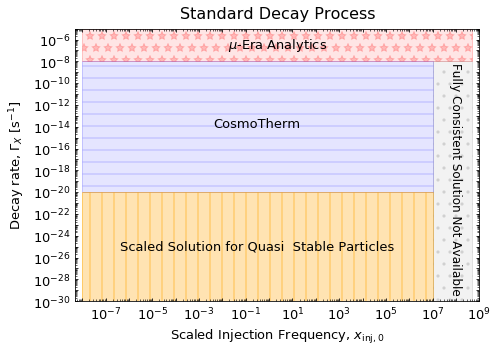

In [415]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


ax.set_xscale('log')
ax.set_yscale('log')

# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)


ax.set_ylabel(r'Decay rate, $\Gamma_X\,\,[\mathrm{s}^{-1}]$',size=title_size)
ax.set_xlabel(label_injection_frequency,size=title_size)
ax.yaxis.set_label_coords(-.12,0.5)

#for label in ax.yaxis.get_ticklabels()[::2]:
#    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)





#ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


#array_x0 =[]
#array_t_stim_today = []
#array_t_today = []

#for i in range(len(R)):
#    xinj0 = R[i]['photon injection x_dec']
#    t_stim_today = R[i]['t_stim'][-1]
#    t_today = R[i]['t_cosmic'][-1]
#    array_x0.append(xinj0 )
#    array_t_stim_today.append(t_stim_today)
#    array_t_today.append(t_today)
#array_x0 = np.asarray(array_x0)
#array_t_stim_today = np.asarray(array_t_stim_today)

#ax.plot(array_x0,array_t_stim_today,c='k')

#ax.plot(array_x0,array_t_today,ls='--',c='b',alpha=0.7)

#array_x0 = np.logspace(-8,8,100)

#z = 0.
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=0$',ls='-',c='k')
#z = 1e2
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{2}$',ls='--',c='k')
#z = 1e4
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{4}$',ls='-.',c='k')
#z = 1e6
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{6}$',ls=':',c='k')

cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#ax.plot(array_x0,4./array_x0/cosmo.H0()/np.sqrt(cosmo.Omega_m()),ls='-.',c='b',alpha=0.7)
#ax.plot(array_x0,1/cosmo.H0()*array_x0/array_x0)


#ax.text(0.2,0.1,r'Age of the Universe $\approx 1/H_0$',transform = ax.transAxes,fontsize= 10)
#ax.text(0.2,0.9,r'Low Frequency Assymptote $\approx 4/(H_0\Omega_\mathrm{m}^{0.5} x_\mathrm{inj,0})$',
#        transform = ax.transAxes,fontsize= 10,rotation=-40,verticalalignment='top')
#ax.legend()

ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-20, 1e-20, 1e-8, 1e-8], fill=True, hatch='-',c='b',alpha=0.1)

ax.fill([1e-8, 5e8, 5e8, 1e-8], [1e-8, 1e-8, 1e-5, 1e-5], fill=True, hatch='*',c='r',alpha=0.1)

ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-30, 1e-30, 1e-20, 1e-20], fill=True, hatch='|',c='orange',alpha=0.3)

ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-20, 1e-20, 1e-8, 1e-8], fill=False, hatch='-',c='b',alpha=0.1)

ax.fill([1e-8, 5e8, 5e8, 1e-8], [1e-8, 1e-8, 1e-5, 1e-5], fill=False, hatch='*',c='r',alpha=0.1)

ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-30, 1e-30, 1e-20, 1e-20], fill=False, hatch='|',c='orange',alpha=0.3)

ax.text(0.45,0.2,r'Scaled Solution for Quasi  Stable Particles',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 13)

ax.text(0.45,0.65,r'CosmoTherm',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 13)



ax.text(0.5,0.94,r'$\mu$-Era Analytics',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 13)


ax.text(0.94,0.45,r'Fully Consistent Solution Not Available',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 12,rotation = -90)


ax.fill([1e7, 5e8, 5e8, 1e7], [1e-30, 1e-30, 1e-8, 1e-8], fill=False, hatch='.',c='grey',alpha=0.1)
ax.fill([1e7, 5e8, 5e8, 1e7], [1e-30, 1e-30, 1e-8, 1e-8], fill=True, hatch='.',c='grey',alpha=0.1)




ax.set_ylim(1.e-5,1e-30)
ax.set_xlim(5.e-9,1e9)
plt.title('Standard Decay Process',pad=10.2,fontsize=16)

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_regions.pdf')
plt.show()
plt.close(fig)

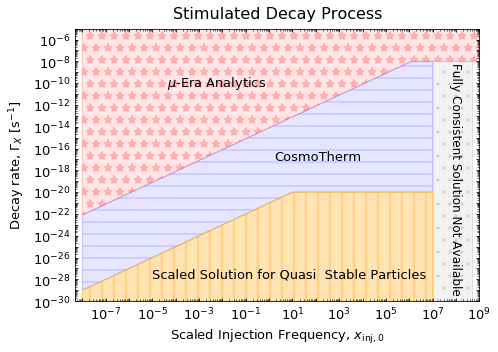

In [428]:

from matplotlib.patches import Ellipse, Polygon

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


ax.set_xscale('log')
ax.set_yscale('log')

# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)


ax.set_ylabel(r'Decay rate, $\Gamma_X\,\,[\mathrm{s}^{-1}]$',size=title_size)
ax.set_xlabel(label_injection_frequency,size=title_size)
ax.yaxis.set_label_coords(-.12,0.5)

#for label in ax.yaxis.get_ticklabels()[::2]:
#    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)





#ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


#array_x0 =[]
#array_t_stim_today = []
#array_t_today = []

#for i in range(len(R)):
#    xinj0 = R[i]['photon injection x_dec']
#    t_stim_today = R[i]['t_stim'][-1]
#    t_today = R[i]['t_cosmic'][-1]
#    array_x0.append(xinj0 )
#    array_t_stim_today.append(t_stim_today)
#    array_t_today.append(t_today)
#array_x0 = np.asarray(array_x0)
#array_t_stim_today = np.asarray(array_t_stim_today)

#ax.plot(array_x0,array_t_stim_today,c='k')

#ax.plot(array_x0,array_t_today,ls='--',c='b',alpha=0.7)

#array_x0 = np.logspace(-8,8,100)

#z = 0.
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=0$',ls='-',c='k')
#z = 1e2
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{2}$',ls='--',c='k')
#z = 1e4
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{4}$',ls='-.',c='k')
#z = 1e6
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{6}$',ls=':',c='k')

cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#ax.plot(array_x0,4./array_x0/cosmo.H0()/np.sqrt(cosmo.Omega_m()),ls='-.',c='b',alpha=0.7)
#ax.plot(array_x0,1/cosmo.H0()*array_x0/array_x0)


#ax.text(0.2,0.1,r'Age of the Universe $\approx 1/H_0$',transform = ax.transAxes,fontsize= 10)
#ax.text(0.2,0.9,r'Low Frequency Assymptote $\approx 4/(H_0\Omega_\mathrm{m}^{0.5} x_\mathrm{inj,0})$',
#        transform = ax.transAxes,fontsize= 10,rotation=-40,verticalalignment='top')
#ax.legend()

#ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-20, 1e-20, 1e-8, 1e-8], fill=True, hatch='-',c='b',alpha=0.3)

#ax.fill([1e-8, 5e8, 5e8, 1e-8], [1e-8, 1e-8, 1e-5, 1e-5], fill=True, hatch='*',c='r',alpha=0.1)

#ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-30, 1e-30, 1e-20, 1e-20], fill=True, hatch='|',c='orange',alpha=0.3)

#ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-20, 1e-20, 1e-8, 1e-8], fill=False, hatch='-',c='b',alpha=0.1)

#ax.fill([1e-8, 5e8, 5e8, 1e-8], [1e-8, 1e-8, 1e-5, 1e-5], fill=False, hatch='*',c='r',alpha=0.1)

#ax.fill([1e-8, 1e7, 1e7, 1e-8], [1e-30, 1e-30, 1e-20, 1e-20], fill=False, hatch='|',c='orange',alpha=0.3)

ax.text(0.53,0.1,r'Scaled Solution for Quasi  Stable Particles',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 13)

ax.text(0.6,0.53,r'CosmoTherm',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 13)



ax.text(0.35,0.8,r'$\mu$-Era Analytics',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 13)


ax.text(0.94,0.45,r'Fully Consistent Solution Not Available',transform=ax.transAxes,
        horizontalalignment='center',verticalalignment='center',fontsize = 12,rotation = -90)


ax.fill([1e7, 5e8, 5e8, 1e7], [1e-30, 1e-30, 1e-8, 1e-8], fill=False, hatch='.',c='grey',alpha=0.1)
ax.fill([1e7, 5e8, 5e8, 1e7], [1e-30, 1e-30, 1e-8, 1e-8], fill=True, hatch='.',c='grey',alpha=0.1)


xa = np.logspace(-8,np.log10(5e8),100)
xa_early = np.logspace(-8,np.log10(1./8.*1e7),100)
xa_late = np.logspace(-8,np.log10(1./8.*1e1),100)
ga_early = 8e-15*xa_early
ga_late = 3e-21*xa_late
#ax.plot(xa_early,ga_early)
#ax.plot(xa_late,ga_late)



#ax.fill_between(xa_late,ga_late,1e-20*xa_late/xa_late,hatch='-',color='b',alpha=1)
#ax.fill_between(xa_late,ga_late,1e-20*xa_late/xa_late,hatch='-',color=None,edgecolor='b',alpha=1)

#ax.fill_between(xa_early,ga_early,1e-8*xa_early/xa_early,hatch='*',color='r',alpha=1)
#ax.fill_between(xa_early,ga_early,1e-8*xa_early/xa_early,hatch='*',color=None,edgecolor='red',alpha=1)



ax.add_patch(Polygon([[1e-8, 1e-21*1e-8], [1e1, 1e-20], 
                       [1e7, 1e-20], [1e7, 1e-8],
                        [1./8.*1e7, 1e-8],[1e-8,8e-15*1e-8]], closed=True,
                      fill=False, hatch='-',color='b',alpha=0.1))

ax.add_patch(Polygon([[1e-8, 1e-21*1e-8], [1e1, 1e-20], 
                       [1e7, 1e-20], [1e7, 1e-8],
                        [1./8.*1e7, 1e-8],[1e-8,8e-15*1e-8]], closed=True,
                      fill=True, hatch='-',color='b',alpha=0.1))



ax.add_patch(Polygon([[1e-8, 1e-30], [1e7, 1e-30], 
                       [1e7, 1e-20], [1e1, 1e-20],
                       [1e-8,1e-21*1e-8]], closed=True,
                      fill=False, hatch='|',color='orange',alpha=0.3))


ax.add_patch(Polygon([[1e-8, 1e-30], [1e7, 1e-30], 
                       [1e7, 1e-20], [1e1, 1e-20],
                       [1e-8,1e-21*1e-8]], closed=True,
                      fill=True, hatch='|',color='orange',alpha=0.3))


ax.add_patch(Polygon([[1e-8, 1e-8*8e-15], [1./8.*1e7, 1e-8],
                     [1e7, 1e-8],[1e9,1e-8],[1e9,1e-5],[1e-8,1e-5]], closed=True,
                      fill=False, hatch='*',color='r',alpha=0.1))


ax.add_patch(Polygon([[1e-8, 1e-8*8e-15], [1./8.*1e7, 1e-8],
                     [1e7, 1e-8],[1e9,1e-8],[1e9,1e-5],[1e-8,1e-5]], closed=True,
                      fill=True, hatch='*',color='r',alpha=0.1))

ax.set_ylim(1.e-5,1e-30)
ax.set_xlim(5.e-9,1e9)

plt.title('Stimulated Decay Process',pad=10.2,fontsize=16)

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_regions_stim.pdf')
plt.show()
plt.close(fig)

In [417]:
cosmo.H0()*np.sqrt(cosmo.Omega_m())/4./1e2

3.0582445596873423e-21

In [416]:
1e-2 * cosmo.H0()

2.1888936296103796e-20

In [339]:
'%.4e'%(1e5/xinj_to_Einj)

'4.2571e+08'

In [203]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = [1e-5]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 0
ct.ct_pi_stim = 0
ct.ct_zlate = 1e3
ct.ct_pi_energy_norm = 2
ct.ct_Drho_rho_dec = 3e-5
ct.ct_lyc = 1
ct.ct_evolve_Xe = 1
ct.ct_include_collisions = 0

ct.ct_Gamma_dec = 1e-6
#ct.ct_pi_redshift_evolution_mode=1
R_test = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-100
R_test_no_inj = ct.run_cosmotherm_parallel(**args)
i=0

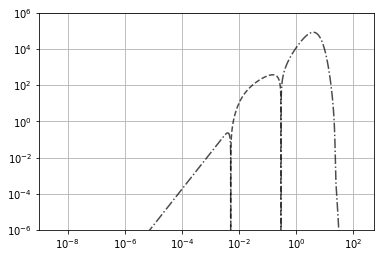

In [204]:
i=0
plt.plot(R_test[i]['x'],(R_test[i]['DI']-R_test_no_inj[i]['DI']),c=col,ls='-.',alpha=0.7)
plt.plot(R_test[i]['x'],-(R_test[i]['DI']-R_test_no_inj[i]['DI']),c=col,ls='--',alpha=0.7)
plt.loglog()
plt.ylim(1e-6,1e6)
plt.grid(which='both')

In [198]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = [1e1,1e0,1e-2,1e-4]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 0
ct.ct_pi_stim = 0
ct.ct_zlate = 1e3
ct.ct_pi_energy_norm = 2
ct.ct_Drho_rho_dec = 3e-5
ct.ct_lyc = 1
ct.ct_evolve_Xe = 1
ct.ct_include_collisions = 0

ct.ct_Gamma_dec = 1e-17
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-100
R_no_inj = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-5
ct.ct_pi_stim = 1
R_stim = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-100
ct.ct_pi_stim = 1
R_stim_no_inj = ct.run_cosmotherm_parallel(**args)

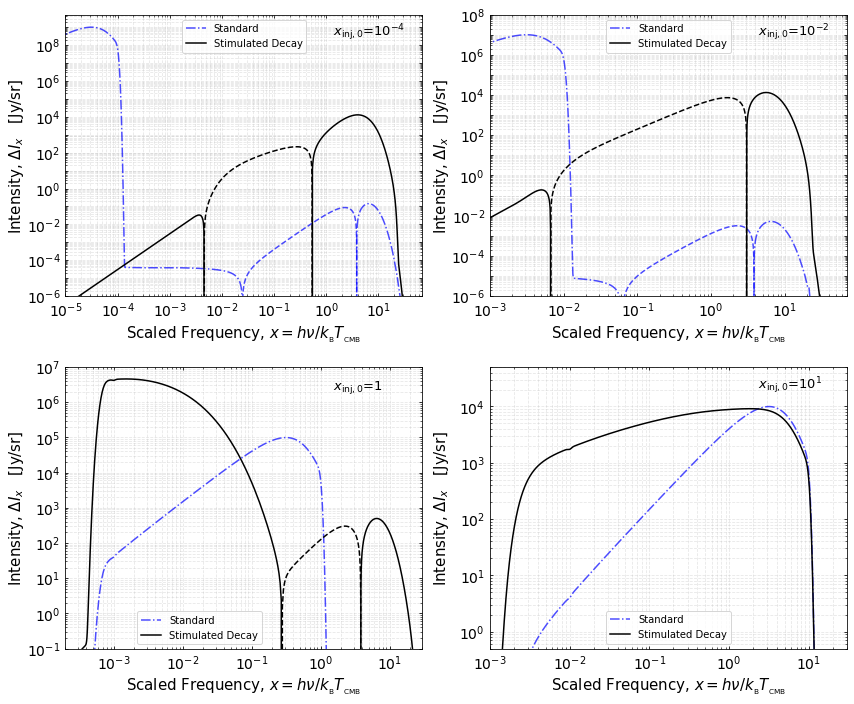

In [224]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
label_size = 14
title_size = 15
legend_size = 25
handle_length = 1.5

color= iter(cm.autumn(np.linspace(0.,0.5,4)))
for (ax,i) in zip((ax1,ax2,ax3,ax4),(3,2,1,0)):
    #ax=ax1

    ax.set_xscale('log')
    ax.set_yscale('log')

    # ymin=1e-6
    # ymax = 2e-2
    # x_min = 1e1
    # x_max = 1e8
    # ax.set_xlim(x_min,x_max)
    # ax.set_ylim(ymin,ymax)


    ax.set_xlabel(label_scaled_frequency ,size=title_size)
    ax.set_ylabel(label_intensity ,size=title_size)
    #ax.set_xlabel(label_injection_frequency,size=title_size)
    ax.yaxis.set_label_coords(-.11,0.5)

    #for label in ax.yaxis.get_ticklabels()[::2]:
    #    label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    #ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    #ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


    locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)


    locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
    ax.yaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    for label in ax.yaxis.get_ticklabels()[::2]:
        if i == 0 or i == 1:
            label.set_visible(True)
        else:
            label.set_visible(False)





    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    #for i in range(len(R)):

    


    
    col = next(color)
    col = 'k'
    #ax.plot(R[i]['x'],(R[i]['DI']-R_no_inj[i]['DI'])/R[i]['finj'],c=col,ls='-.',alpha=0.7)
    #ax.plot(R[i]['x'],-(R[i]['DI']-R_no_inj[i]['DI'])/R[i]['finj'],ls='--',c=col,alpha=0.7)

    #ax.plot(R[i]['x'],(R_stim[i]['DI']-R_stim_no_inj[i]['DI'])/R_stim[i]['finj'],c=col)
    #ax.plot(R_stim[i]['x'],-(R_stim[i]['DI']-R_stim_no_inj[i]['DI'])/R_stim[i]['finj'],ls='--',c=col)

    ax.plot(R[i]['x'],(R[i]['DI']-R_no_inj[i]['DI']),c='b',ls='-.',alpha=0.7,label='Standard')
    ax.plot(R[i]['x'],-(R[i]['DI']-R_no_inj[i]['DI']),ls='--',c='b',alpha=0.7)

    ax.plot(R[i]['x'],(R_stim[i]['DI']-R_stim_no_inj[i]['DI']),c=col,label='Stimulated Decay')
    ax.plot(R_stim[i]['x'],-(R_stim[i]['DI']-R_stim_no_inj[i]['DI']),ls='--',c=col)

    #ax.legend()
    
    #ax.text(0.05,  0.05,r'$x_\mathrm{inj,0}$=%s'%scientific_notation(R[i]['photon injection x_dec']),fontsize=13,transform=ax.transAxes,color='k',verticalalignment='bottom',)

    if i == 0:
        ax.set_ylim(5.e-1,5e4)
        ax.set_xlim(1.e-3,3e1)
        ax.text(0.75,  0.9,r'$x_\mathrm{inj,0}$=%s'%scientific_notation(R[i]['photon injection x_dec']),fontsize=13,transform=ax.transAxes,color='k',verticalalignment='bottom',)
        ax.legend(loc='lower center')
    

    if i == 1:
        ax.set_ylim(1.e-1,1e7)
        ax.set_xlim(2.e-4,3e1)
        ax.text(0.75,  0.9,r'$x_\mathrm{inj,0}$=%s'%scientific_notation(R[i]['photon injection x_dec']),fontsize=13,transform=ax.transAxes,color='k',verticalalignment='bottom',)
        ax.legend(loc=(0.2,0.015))

    if i == 2:
        ax.text(0.75,  0.9,r'$x_\mathrm{inj,0}$=%s'%scientific_notation(R[i]['photon injection x_dec']),fontsize=13,transform=ax.transAxes,color='k',verticalalignment='bottom',)
        ax.set_ylim(1.e-6,1e8)
        ax.set_xlim(1.e-3,7e1)
        ax.legend(loc='upper center')
        

    if i == 3:
        ax.text(0.75,  0.9,r'$x_\mathrm{inj,0}$=%s'%scientific_notation(R[i]['photon injection x_dec']),fontsize=13,transform=ax.transAxes,color='k',verticalalignment='bottom',)
        ax.set_ylim(1.e-6,5e9)
        ax.set_xlim(1.e-5,7e1)
        ax.legend(loc='upper center')

fig.tight_layout(pad=1.5)
plt.savefig(path_to_figures + '/figures_for_paper_DI_stim_G_1e-17_Drho_rho_3e-5.pdf')
plt.show()
plt.close(fig)


In [226]:
1e-8/3e5/4

8.333333333333334e-15

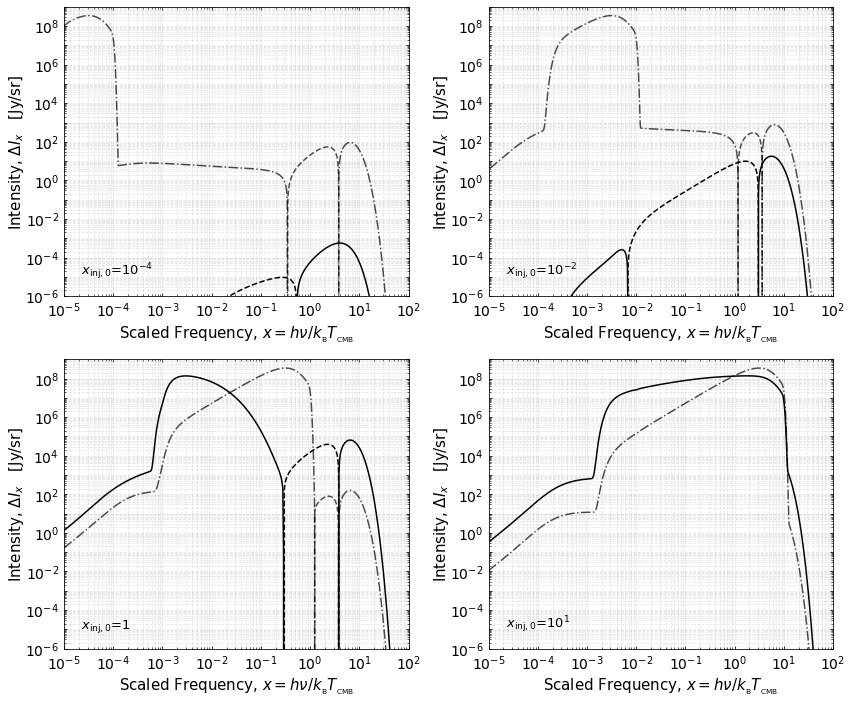

In [184]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
label_size = 14
title_size = 15
legend_size = 25
handle_length = 1.5

color= iter(cm.autumn(np.linspace(0.,0.5,4)))
for (ax,i) in zip((ax1,ax2,ax3,ax4),(3,2,1,0)):
    #ax=ax1

    ax.set_xscale('log')
    ax.set_yscale('log')

    # ymin=1e-6
    # ymax = 2e-2
    # x_min = 1e1
    # x_max = 1e8
    # ax.set_xlim(x_min,x_max)
    # ax.set_ylim(ymin,ymax)


    ax.set_xlabel(label_scaled_frequency ,size=title_size)
    ax.set_ylabel(label_intensity ,size=title_size)
    #ax.set_xlabel(label_injection_frequency,size=title_size)
    ax.yaxis.set_label_coords(-.11,0.5)

    #for label in ax.yaxis.get_ticklabels()[::2]:
    #    label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    #ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    #ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


    locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)


    locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
    ax.yaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)





    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    #for i in range(len(R)):

    


    
    col = next(color)
    col = 'k'
    ax.plot(R[i]['x'],(R[i]['DI']-R_no_inj[i]['DI'])/R[i]['finj'],c=col,ls='-.',alpha=0.7)
    ax.plot(R[i]['x'],-(R[i]['DI']-R_no_inj[i]['DI'])/R[i]['finj'],ls='--',c=col,alpha=0.7)

    ax.plot(R[i]['x'],(R_stim[i]['DI']-R_stim_no_inj[i]['DI'])/R_stim[i]['finj'],c=col)
    ax.plot(R_stim[i]['x'],-(R_stim[i]['DI']-R_stim_no_inj[i]['DI'])/R_stim[i]['finj'],ls='--',c=col)

    #ax.legend()
    
    ax.text(0.05,  0.05,r'$x_\mathrm{inj,0}$=%s'%scientific_notation(R[i]['photon injection x_dec']),fontsize=13,transform=ax.transAxes,color='k',verticalalignment='bottom',)

    
    ax.set_ylim(1.e-6,1e9)
    ax.set_xlim(1.e-5,1e2)

fig.tight_layout(pad=1.5)
plt.savefig(path_to_figures + '/figures_for_paper_DI_stim_G_1e-17_Drho_rho_3e-5.pdf')
plt.show()
plt.close(fig)


'$x_\\mathrm{0}$=$10^{1}$'

In [2]:
Gamma_inj_min = 1e-18
Gamma_inj_max = 1e-8
N_Gamma_inj = 11
Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
Gamma_values = [1e-25,1e-23,1e-21,1e-19,1e-17,1e-15]
N_Gamma_inj = len(Gamma_values)



ngamma = N_Gamma_inj 


args = {}
args['param_values_array'] = Gamma_values
args['param_name'] = 'photon injection Gamma_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

In [29]:
Gamma_inj_min = 1e-18
Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
Gamma_values = [5e-14]
N_Gamma_inj = len(Gamma_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

ngamma = N_Gamma_inj 

args = {}
args['param_values_array'] = Gamma_values
args['param_name'] = 'photon injection Gamma_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
ct.ct_x_dec = 1e40
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

In [26]:
Gamma_inj_min = 1e-20
Gamma_inj_max = 1e-8
N_Gamma_inj = 50
Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
#xinj_values = [1e40,1e1,1e0,1e-2,1e-4]
#xinj_values = [1e0]


N_gamma_inj = len(Gamma_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

ngamma = N_gamma_inj 

args = {}
args['param_values_array'] = Gamma_values
args['param_name'] = 'photon injection Gamma_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 0
ct.ct_Gamma_dec = 1e-17
ct.ct_pi_energy_norm = 2
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
print(ct.ct_x_dec)

1e-06


In [27]:
xdec1 = 1e6
ct.ct_x_dec = xdec1
ct.ct_pi_stim = 1
R1 = ct.run_cosmotherm_parallel(**args)

print(ct.ct_x_dec)

1000000.0


In [33]:
xdec2 = 1e3
ct.ct_x_dec = xdec2
ct.ct_pi_stim = 1
R2 = ct.run_cosmotherm_parallel(**args)

print(ct.ct_x_dec)

1000.0


In [38]:
xdec3 = 1e0
ct.ct_x_dec = xdec3
ct.ct_pi_stim = 1
R3 = ct.run_cosmotherm_parallel(**args)

print(ct.ct_x_dec)



1.0


In [43]:
xdec4 = 1e-3
ct.ct_x_dec = xdec4
ct.ct_pi_stim = 1
R4 = ct.run_cosmotherm_parallel(**args)

print(ct.ct_x_dec)

xdec5 = 1e-6
ct.ct_x_dec = xdec5
ct.ct_pi_stim = 1
R5 = ct.run_cosmotherm_parallel(**args)

print(ct.ct_x_dec)


0.001
1e-06


In [50]:
array_fdm = []
for i in range(N_Gamma_inj):
    fdm = R[i]['finj']*1e-6/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )
    array_fdm.append(fdm)

array_fdm1 = []
for i in range(N_Gamma_inj):
    fdm = R1[i]['finj']*xdec1/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )
    array_fdm1.append(fdm)
    
array_fdm2 = []
for i in range(N_Gamma_inj):
    fdm = R2[i]['finj']*xdec2/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )
    array_fdm2.append(fdm)

array_fdm3 = []
for i in range(N_Gamma_inj):
    fdm = R3[i]['finj']*xdec3/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )
    array_fdm3.append(fdm)

array_fdm4 = []
for i in range(N_Gamma_inj):
    fdm = R4[i]['finj']*xdec4/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )
    array_fdm4.append(fdm)

array_fdm5 = []
for i in range(N_Gamma_inj):
    fdm = R5[i]['finj']*xdec5/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )
    array_fdm5.append(fdm)
    
array_fdm1 = np.asarray(array_fdm1)
array_fdm2 = np.asarray(array_fdm2)
array_fdm3 = np.asarray(array_fdm3)
array_fdm4 = np.asarray(array_fdm4)
array_fdm5 = np.asarray(array_fdm5)


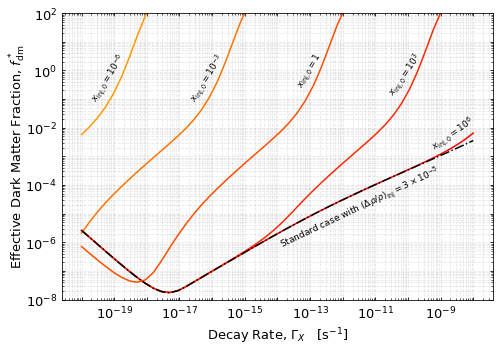

In [112]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


ax.set_xscale('log')
ax.set_yscale('log')

# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)


ax.set_xlabel(label_Gamma ,size=title_size)
ax.set_ylabel(r'Effective Dark Matter Fraction, $f_\mathrm{dm}^*$' ,size=title_size)
#ax.set_xlabel(label_injection_frequency,size=title_size)
ax.yaxis.set_label_coords(-.08,0.5)

#for label in ax.yaxis.get_ticklabels()[::2]:
#    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')




array_x0 = np.logspace(-8,7,100)


color=iter(cm.autumn(np.linspace(0.,0.6,5)))

ax.plot(Gamma_values[array_fdm1>0],array_fdm1[array_fdm1>0],label=r'Stimulated case 1',ls='-',c=next(color))
ax.plot(Gamma_values[array_fdm2>0],array_fdm2[array_fdm2>0],label=r'Stimulated case 2',ls='-',c=next(color))
ax.plot(Gamma_values[array_fdm3>0],array_fdm3[array_fdm3>0],label=r'Stimulated case 3',ls='-',c=next(color))
ax.plot(Gamma_values[array_fdm4>0],array_fdm4[array_fdm4>0],label=r'Stimulated case 3',ls='-',c=next(color))
ax.plot(Gamma_values[array_fdm5>0],array_fdm5[array_fdm5>0],label=r'Stimulated case 3',ls='-',c=next(color))


ax.plot(Gamma_values,array_fdm,label=r'Standard case',ls='-.',c='k')


#z = 1e2
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{2}$',ls='--',c='k')
#z = 1e4
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{4}$',ls='-.',c='k')
#z = 1e6
#ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{6}$',ls=':',c='k')


ax.text(0.06, 0.87, r'$x_\mathrm{inj,0} = 10^{-6}$', fontsize=9,transform=ax.transAxes,color='k',verticalalignment='top',
        rotation=58)

ax.text(0.29,  0.87,  r'$x_\mathrm{inj,0} = 10^{-3}$', fontsize=9,transform=ax.transAxes,color='k',verticalalignment='top',
        rotation=58)

ax.text(0.54,  0.87,  r'$x_\mathrm{inj,0} = 1$', fontsize=9,transform=ax.transAxes,color='k',verticalalignment='top',
        rotation=60)


ax.text(0.75,  0.87,  r'$x_\mathrm{inj,0} = 10^{3}$', fontsize=9,transform=ax.transAxes,color='k',verticalalignment='top',
        rotation=55)

ax.text(0.85,  0.65,  r'$x_\mathrm{inj,0} = 10^{6}$', fontsize=9,transform=ax.transAxes,color='k',verticalalignment='top',
        rotation=35)


ax.text(0.5,  0.48,  r'Standard case with $(\Delta \rho/\rho)_\mathrm{inj}= 3\times 10^{-5}$', fontsize=9,transform=ax.transAxes,color='k',verticalalignment='top',
        rotation=25.5)





#ax.legend()

ax.set_ylim(1.e-8,1e2)
#ax.set_xlim(5.e-9,3e7)

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_fdm_vs_Gamma_X_Drho_rho_3e-5.pdf')
plt.show()
plt.close(fig)

In [12]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
#xinj_values = [1e40,1e1,1e0,1e-2,1e-4]
xinj_values = [1e0]


N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 0
ct.ct_Gamma_dec = 1e-17
ct.ct_pi_energy_norm = 2
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

In [13]:
R[0]['finj']*R[0]['photon injection x_dec']/( pi.G3/pi.G2*cosmo.Omega_cdm()/cosmo.Omega_g() )

2.1598650030215695e-08

In [2]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = [1e40,1e1,1e0,1e-2,1e-4]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
ct.ct_Gamma_dec = 1e-17
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

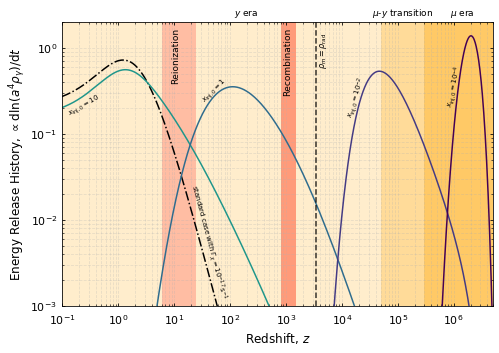

1e-17


In [3]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5


x_min = 1.e-1
x_max = 5.e6
x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.98, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9,verticalalignment='top')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.98, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9,verticalalignment='top')



color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))

i = 0
for r,Gamma_asked in zip(R,xinj_values):
    #print(Gamma_asked)

    col = next(color)
    slabel = r"$x_\mathrm{inj,0} = $"+scientific_notation(Gamma_asked)
    if i==0:
        ax.plot(r["z"],r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"],c='k',ls='-.',alpha=1.,label=slabel)
    else:
        ax.plot(r["z"],r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"],c=col,ls='-',alpha=1.,label=slabel)
    #ax.plot(r["z"],r["(NX/Nxini)_stim"],c=col,ls='--',alpha=1.)
    
    #ct.ct_Gamma_dec = Gamma_asked
    #cosmo = pi.cosmo()
    #pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    #try:
    #    zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    #except:
    #    zX = 0.
    i+=1
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.595, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)




ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-75)

ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=30)


ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=45)

ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=73)


ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=78)



#ax.legend()

ax.loglog()

fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_drho_rho_energy_mode_G_1e-17.pdf')
plt.show()
plt.close(fig)
print(ct.ct_Gamma_dec)

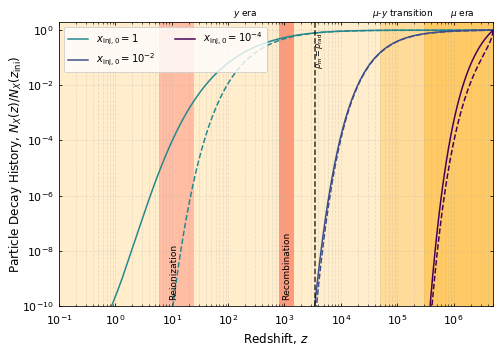

In [19]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5


x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-10
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
#ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.03, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9)

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.03, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9)



color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))

i = 0
for r,Gamma_asked in zip(R,xinj_values):
    #print(Gamma_asked)
    col = next(color)
    if i >=1:
        slabel =r"$x_\mathrm{inj,0} = $"+scientific_notation(Gamma_asked)
        #ax.plot(r["z"],r["(NX/Nxini)"],c=col,ls='-',alpha=1.,label=slabel)
        ax.plot(r["z"],r["(NX/Nxini)_stim"],c=col,ls='-',alpha=1.,label=slabel)

        cosmo = pi.cosmo()
        pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
        
        #ax.plot(r["z"],np.exp(-ct.ct_Gamma_dec*(r["t_stim"]-r["t_stim"][0])),marker='o',markersize=1)

        
        #ax.plot(r["z"],np.exp(-ct.ct_Gamma_dec*cosmo.Omega_rel()**0.5*cosmo.H0()*Gamma_asked**2./8.*(r["t_cosmic"]-r["t_cosmic"][0])**2.),marker='o',markersize=1)
        ax.plot(r["z"],np.exp(-ct.ct_Gamma_dec*cosmo.Omega_rel()**-0.25*cosmo.H0()**-0.5*Gamma_asked**-1.*2.*np.sqrt(2)*(r["t_cosmic"]-r["t_cosmic"][0])**0.5),c=col,ls='--')

    
    #ct.ct_Gamma_dec = Gamma_asked

    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    #try:
    #    zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    #except:
    #    zX = 0.
    i+=1

ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.588, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)

#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
#ax.text(0.03, 0.875, r'$\Gamma_X = 10^{-18}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-30)


#ax.text(0.01, 0.71, r'$\Gamma_X = 10^{-17}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)

#ax.text(0.255, 0.671, r'$\Gamma_X = 5\times 10^{-16}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)

#ax.text(0.425, 0.671, r'$\Gamma_X = 5\times 10^{-14}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)

#ax.text(0.6825, 0.71, r'$\Gamma_X = 10^{-11}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-74)

#ax.text(0.88, 0.71, r'$\Gamma_X = 10^{-8}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
 #       rotation=-74)




ax.loglog()
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm)
# cbar.set_ticks([0.,0.2,0.4,0.6,0.8,1.])
# cbar.ax.set_yticklabels([r'$10^{-8}$',r'$10^{-10}$',r'$10^{-12}$',r'$10^{-14}$',r'$10^{-16}$',r'$10^{-18}$'])
# cbar.ax.set_title(r'$\Gamma_\mathrm{inj}\,[\mathrm{s}^{-1}]$')
ax.legend(loc=2,ncol=2)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_NX_NX_ini_G_1e-11.pdf')
plt.show()
plt.close(fig)

In [91]:
ct.ct_Gamma_dec

1e-11

2.620172142723356e-33

In [5]:
z_array = []
Drho_array = []
i=0
for r,Gamma_asked in zip(R,Gamma_values):
    #print(Gamma_asked)

    #col = next(color)
    #slabel = r"$\Gamma_\mathrm{inj} = $"+scientific_notation(Gamma_asked)
    #ax.plot(r["z"],r["dDrho_rhodt_rel"],c=col,label=slabel)
    
    ct.ct_Gamma_dec = Gamma_asked
    cosmo = pi.cosmo()
    pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
    z_array.append(np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200))
    #Drho_array.append(pi.Drho_rho_inj_at_z_normalized(z_array[i],cosmo,ct))
    i+=1

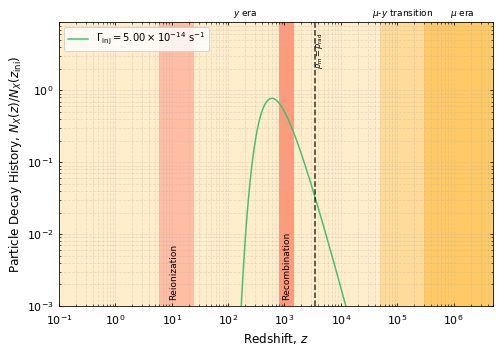

In [31]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5


x_min = 1.e-1
x_max = 5.e6
x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 9e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
#ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.03, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9)

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.03, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9)



color=iter(cm.viridis(np.linspace(0.7,0.,ngamma)))

i = 0
for r,Gamma_asked in zip(R,Gamma_values):
    #print(Gamma_asked)

    col = next(color)
    slabel = r"$\Gamma_\mathrm{inj} = $"+scientific_notation(Gamma_asked) + r" $\mathrm{s}^{-1}$"
    ax.plot(r["z"],r["[(dlnRho/dln1pz)/(dRho/Rho)_inj]"],c=col,ls='-',alpha=1.,label=slabel)
    #ax.plot(r["z"],r["(NX/Nxini)_stim"],c=col,ls='--',alpha=1.)
    
    ct.ct_Gamma_dec = Gamma_asked
    cosmo = pi.cosmo()
    pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    try:
        zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    except:
        zX = 0.
    i+=1

ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.588, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)

#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
#ax.text(0.03, 0.875, r'$\Gamma_X = 10^{-18}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-30)


#ax.text(0.01, 0.71, r'$\Gamma_X = 10^{-17}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)

#ax.text(0.255, 0.671, r'$\Gamma_X = 5\times 10^{-16}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)

#ax.text(0.425, 0.671, r'$\Gamma_X = 5\times 10^{-14}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)

#ax.text(0.6825, 0.71, r'$\Gamma_X = 10^{-11}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-74)

#ax.text(0.88, 0.71, r'$\Gamma_X = 10^{-8}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
 #       rotation=-74)




ax.loglog()
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm)
# cbar.set_ticks([0.,0.2,0.4,0.6,0.8,1.])
# cbar.ax.set_yticklabels([r'$10^{-8}$',r'$10^{-10}$',r'$10^{-12}$',r'$10^{-14}$',r'$10^{-16}$',r'$10^{-18}$'])
# cbar.ax.set_title(r'$\Gamma_\mathrm{inj}\,[\mathrm{s}^{-1}]$')
ax.legend(loc=2,ncol=2)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_drho_rho_energy_mode_2.pdf')
plt.show()
plt.close(fig)

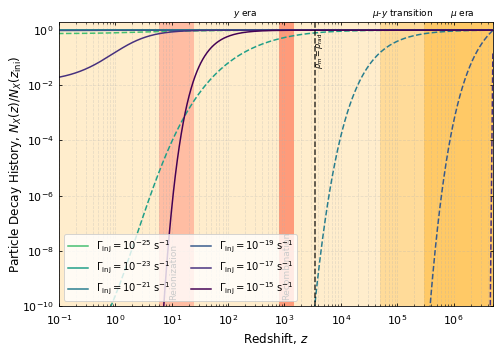

In [21]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5


x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-10
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
#ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.03, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9)

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.03, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9)



color=iter(cm.viridis(np.linspace(0.7,0.,ngamma)))

i = 0
for r,Gamma_asked in zip(R,Gamma_values):
    #print(Gamma_asked)

    col = next(color)
    slabel = r"$\Gamma_\mathrm{inj} = $"+scientific_notation(Gamma_asked) + r" $\mathrm{s}^{-1}$"
    ax.plot(r["z"],r["(NX/Nxini)"],c=col,ls='-',alpha=1.,label=slabel)
    ax.plot(r["z"],r["(NX/Nxini)_stim"],c=col,ls='--',alpha=1.)
    
    ct.ct_Gamma_dec = Gamma_asked
    cosmo = pi.cosmo()
    pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    try:
        zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    except:
        zX = 0.
    i+=1

ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.588, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)

#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
#ax.text(0.03, 0.875, r'$\Gamma_X = 10^{-18}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-30)


#ax.text(0.01, 0.71, r'$\Gamma_X = 10^{-17}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)

#ax.text(0.255, 0.671, r'$\Gamma_X = 5\times 10^{-16}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)

#ax.text(0.425, 0.671, r'$\Gamma_X = 5\times 10^{-14}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)

#ax.text(0.6825, 0.71, r'$\Gamma_X = 10^{-11}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-74)

#ax.text(0.88, 0.71, r'$\Gamma_X = 10^{-8}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
 #       rotation=-74)




ax.loglog()
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm)
# cbar.set_ticks([0.,0.2,0.4,0.6,0.8,1.])
# cbar.ax.set_yticklabels([r'$10^{-8}$',r'$10^{-10}$',r'$10^{-12}$',r'$10^{-14}$',r'$10^{-16}$',r'$10^{-18}$'])
# cbar.ax.set_title(r'$\Gamma_\mathrm{inj}\,[\mathrm{s}^{-1}]$')
ax.legend(loc=3,ncol=2)
fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_NX_NX_ini.pdf')
plt.show()
plt.close(fig)

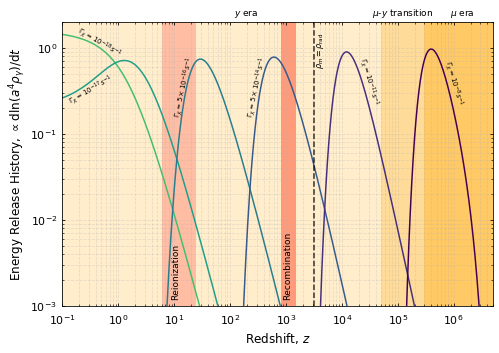

In [12]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5




ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.03, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9)

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.03, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9)



color=iter(cm.viridis(np.linspace(0.7,0.,ngamma)))

i = 0
for r,Gamma_asked in zip(R,Gamma_values):
    #print(Gamma_asked)

    col = next(color)
    slabel = r"$\Gamma_\mathrm{inj} = $"+scientific_notation(Gamma_asked)
    ax.plot(r["z"],r["dDrho_rhodt_rel"],c=col,ls='-',alpha=1.,label=slabel)
    
    ct.ct_Gamma_dec = Gamma_asked
    cosmo = pi.cosmo()
    pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    try:
        zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    except:
        zX = 0.
    i+=1

ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.588, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)

#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
ax.text(0.03, 0.875, r'$\Gamma_X = 10^{-18}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-30)


ax.text(0.01, 0.71, r'$\Gamma_X = 10^{-17}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=30)

ax.text(0.255, 0.671, r'$\Gamma_X = 5\times 10^{-16}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=78)

ax.text(0.425, 0.671, r'$\Gamma_X = 5\times 10^{-14}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=78)

ax.text(0.6825, 0.71, r'$\Gamma_X = 10^{-11}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-74)

ax.text(0.88, 0.71, r'$\Gamma_X = 10^{-8}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-74)




ax.loglog()
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm)
# cbar.set_ticks([0.,0.2,0.4,0.6,0.8,1.])
# cbar.ax.set_yticklabels([r'$10^{-8}$',r'$10^{-10}$',r'$10^{-12}$',r'$10^{-14}$',r'$10^{-16}$',r'$10^{-18}$'])
# cbar.ax.set_title(r'$\Gamma_\mathrm{inj}\,[\mathrm{s}^{-1}]$')

fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_drho_rho.pdf')
plt.show()
plt.close(fig)

In [2]:
sd.path_to_cosmotherm

'/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr'

In [3]:
t_stim = np.loadtxt(sd.path_to_cosmotherm+'/t_stim.dat')

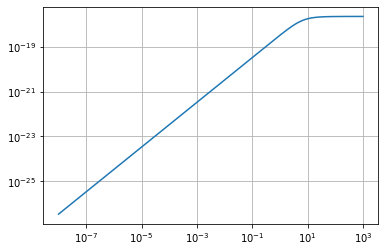

In [10]:
plt.plot(t_stim[:,0],t_stim[:,2])
plt.loglog()
plt.grid(which='both')

In [ ]:
        ofile << x << " " << 1.0/cosm.t(0.0) << " " << 1.0/t_dec_stim(0.0, x, cosm)
                   << " " << cosm.H(0)*x/7.0 << endl;

In [12]:
drho_stim = np.loadtxt(sd.path_to_cosmotherm+'/outputs/energetics.cooling.photon_inj.PDE_ODE.pistim.dat')

(0.01, 10000000.0)

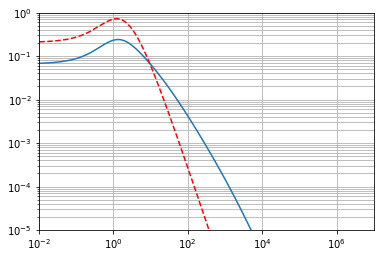

In [74]:
plt.plot(drho_stim[:,0],drho_stim[:,17]/drho_stim[:,18][-1])
plt.plot(drho_stim[:,0],drho_stim[:,16]/drho_stim[:,19][-1],c='r',ls='--')
#plt.plot(drho_stim[:,0],-drho_stim[:,18], ls='--')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e-5,1e0)
plt.xlim(1e-2,1e7)

(0.01, 10000000.0)

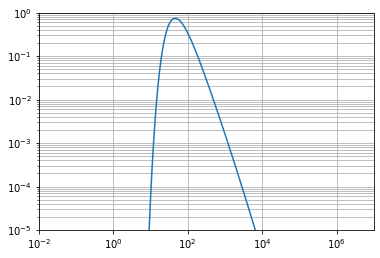

In [13]:
plt.plot(drho_stim[:,0],drho_stim[:,16]/drho_stim[:,18][-1])
#plt.plot(drho_stim[:,0],drho_stim[:,16]/drho_stim[:,19][-1],c='r',ls='--')
#plt.plot(drho_stim[:,0],-drho_stim[:,18], ls='--')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e-5,1e0)
plt.xlim(1e-2,1e7)

(0.01, 10000000.0)

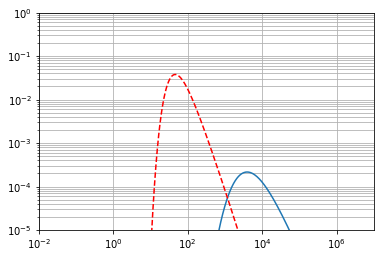

In [72]:
plt.plot(drho_stim[:,0],drho_stim[:,17])
plt.plot(drho_stim[:,0],drho_stim[:,16],c='r',ls='--')
#plt.plot(drho_stim[:,0],-drho_stim[:,18], ls='--')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e-5,1e0)
plt.xlim(1e-2,1e7)

In [2]:
def xinj_at_z(x0,z):
    return x0/(1.+z)

def n_bb(x):
    return (np.exp(x)-1.)**-1.




def Gamma_stim_over_Gamma_X(xinj0,zp):
    xinj = xinj_at_z(xinj0,zp)
    return (1.+2*n_bb(xinj))



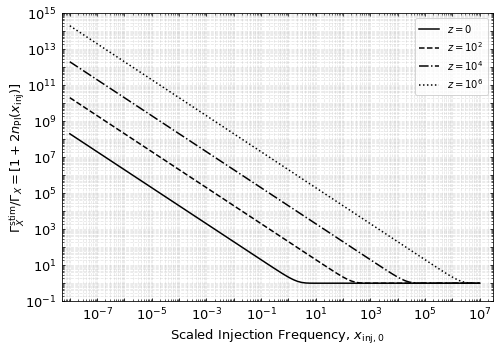

In [3]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


ax.set_xscale('log')
ax.set_yscale('log')

# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)


ax.set_ylabel(label_Gamma_stim,size=title_size)
ax.set_xlabel(label_injection_frequency,size=title_size)
ax.yaxis.set_label_coords(-.08,0.5)

#for label in ax.yaxis.get_ticklabels()[::2]:
#    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')




array_x0 = np.logspace(-8,7,100)

z = 0.
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=0$',ls='-',c='k')
z = 1e2
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{2}$',ls='--',c='k')
z = 1e4
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{4}$',ls='-.',c='k')
z = 1e6
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{6}$',ls=':',c='k')





ax.legend()

ax.set_ylim(1.e-1,1e15)
ax.set_xlim(5.e-9,3e7)

fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_Gamma_stim.pdf')
plt.show()
plt.close(fig)